In [ ]:
# TTS_PATH = "/home/erogol/projects/"

In [1]:
import os
import sys
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.config.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from formatters import custom_bulgarian_formatter
%matplotlib inline

In [2]:
NUM_PROC = 24
DATASET_CONFIG = BaseDatasetConfig(
    formatter="ljspeech", meta_file_train="metadata.csv", path="output_audio"
)

In [3]:
def formatter(root_path, meta_file, **kwargs):  # pylint: disable=unused-argument
    txt_file = os.path.join(root_path, meta_file)
    items = []
    speaker_name = "1"
    with open(txt_file, "r", encoding="utf-8") as ttf:
        for line in ttf:
            cols = line.split("|")
            wav_file = os.path.join(root_path, "wavs", cols[0] + ".wav")            
            text = cols[1]
            items.append({"text": text, "audio_file": wav_file, "speaker_name": speaker_name, "root_path": root_path})
    return items

In [4]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
train_samples, eval_samples = load_tts_samples(DATASET_CONFIG, eval_split=True, formatter=custom_bulgarian_formatter)
if eval_samples is not None:
    items = train_samples + eval_samples
else:
    items = train_samples
print(" > Number of audio files: {}".format(len(items)))
print(items[1])

 | > Found 20513 files in /home/metodi/dev/text-to-speech/output_audio
 > Number of audio files: 20513
{'text': 'Всъщност донякъде каза точно това  опроверга го Наоми.', 'audio_file': 'output_audio/sentence18653.wav', 'speaker': '1', 'speaker_name': '1', 'root_path': 'output_audio', 'language': '', 'audio_unique_name': '#sentence18653'}


In [5]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item["audio_file"].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(wav_file)

In [6]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [7]:
item

{'text': 'Хванете този човек.',
 'audio_file': 'output_audio/sentence16646.wav',
 'speaker': '1',
 'speaker_name': '1',
 'root_path': 'output_audio',
 'language': '',
 'audio_unique_name': '#sentence16646'}

In [8]:
def load_item(item):
    text = item["text"].strip()
    file_name = item["audio_file"].strip()
    audio, sr = librosa.load(file_name, sr=None)
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

/tmp/ipykernel_2050646/4188986729.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  data = list(tqdm(p.imap(load_item, items), total=len(items)))


  0%|          | 0/20513 [00:00<?, ?it/s]

In [9]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

/tmp/ipykernel_2050646/2126754372.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/20513 [00:00<?, ?it/s]

 > Number of words: 24267


In [10]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

/tmp/ipykernel_2050646/1322472053.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/20513 [00:00<?, ?it/s]

In [11]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [12]:
for item in data:
    if item[-1] < 2:
        print(item)

('output_audio/sentence440.wav', 'Бившата ми жена.', 16, array([0.0000000e+00, 3.0517578e-05, 3.0517578e-04, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), 1.9)
('output_audio/sentence7242.wav', 'От къде идвате?', 15, array([3.0517578e-05, 3.0517578e-05, 9.1552734e-05, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), 1.8)
('output_audio/sentence5096.wav', 'Да си общуваме.', 15, array([-6.1035156e-05, -3.0517578e-05,  2.1362305e-04, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32), 1.8124716553287983)
('output_audio/sentence5169.wav', 'Седна на ръба му.', 17, array([-0.00015259,  0.        ,  0.00027466, ...,  0.        ,
        0.        ,  0.        ], dtype=float32), 1.8374603174603175)
('output_audio/sentence9284.wav', 'Като например?', 14, array([0.0000000e+00, 3.0517578e-05, 2.4414062e-04, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), 1.7124716553287982)
('output_audio/sente

In [14]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
sec_per_char /= len(data)
print(sec_per_char)

5.484225195986929e-06


In [15]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.20058961685559956
0.26201021470161734


In [16]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        print(item)

('output_audio/sentence19510.wav', '"Качили са се на друг кораб', 27, array([-0.00030518, -0.00042725, -0.00033569, ...,  0.        ,
        0.        ,  0.        ], dtype=float32), 7.187482993197279)
('output_audio/sentence6668.wav', '"Бяха й казали', 14, array([-3.0517578e-05,  6.1035156e-05,  3.3569336e-04, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32), 3.274965986394558)
('output_audio/sentence15973.wav', '3981 метра.', 11, array([6.1035156e-05, 1.5258789e-04, 3.9672852e-04, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), 3.5499773242630384)
('output_audio/sentence15818.wav', '"Ето защо предварителните преговори', 35, array([6.1035156e-05, 3.0517578e-05, 1.5258789e-04, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), 10.049977324263038)
('output_audio/sentence13496.wav', '"По-късно', 9, array([-0.00024414, -0.00036621, -0.00033569, ...,  0.        ,
        0.        ,  0.        ], dtype=float32), 3

### Plot Dataset Statistics

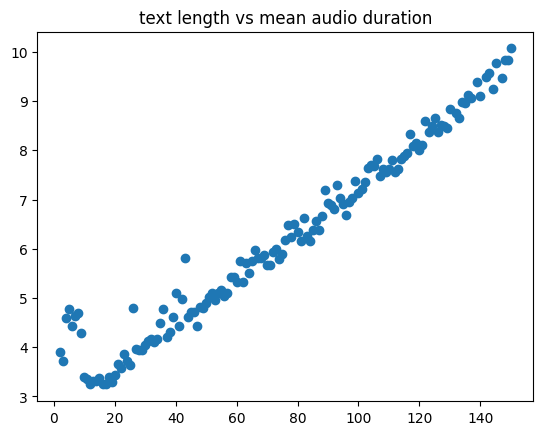

In [17]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

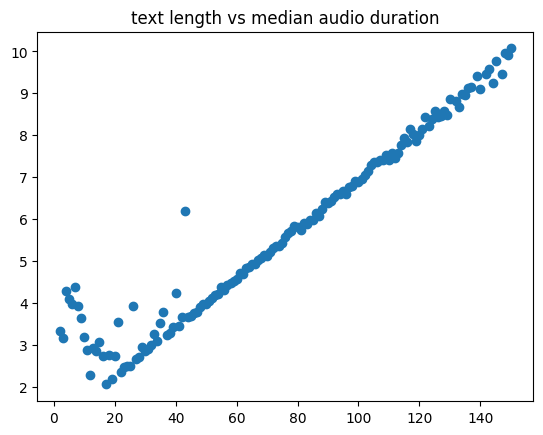

In [18]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

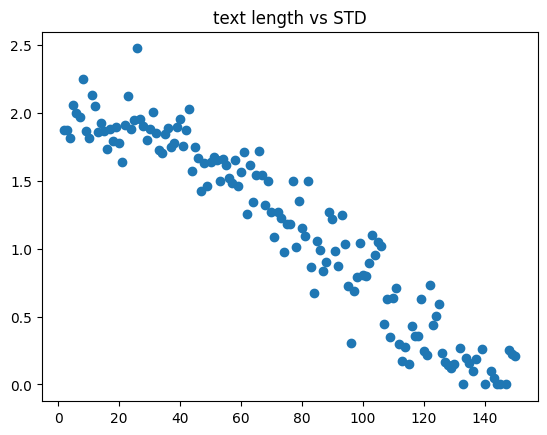

In [19]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

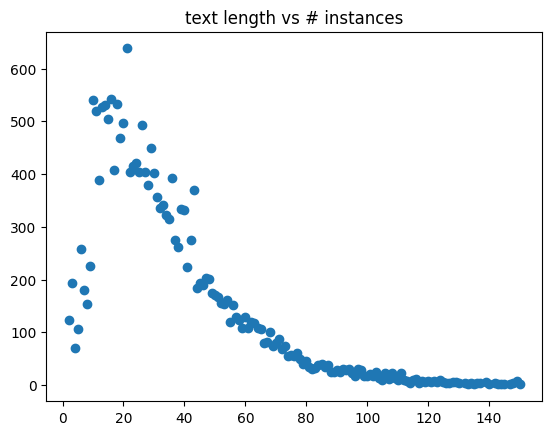

In [20]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [21]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [22]:
w_count_df

,0
на,3911
и,3278
се,3249
да,3082
е,2553
...,...
твърдяха,1
персонал,1
имахте,1
вярвах,1


In [24]:
# check a certain word
w_count_df.at['галактика', 0]

5

In [ ]:
# fequency bar plot - it takes time!! - requires refiniment, plot is unsusable
w_count_df.plot.bar()